<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Quickstart: Web Cam Object Detection


Object detection is the canonical computer vision task of determining where a specific object is in an image.

This notebook shows a simple example of loading a pretrained Faster R-CNN model for object detection from a webcam stream using the `torchvision` package.

To understand the basics of Object Detection, please visit our [FAQ](FAQ.md).  For more details about the underlying technology of object detection tasks\, including finetuning, please see our [training introduction notebook](01_training_introduction.ipynb).

## Prerequisite for Webcam example 
This notebook assumes you have **a webcam** connected to your machine.  We use the `ipywebrtc` module to show the webcam widget in the notebook. Currently, the widget works on **Chrome** and **Firefox**. For more details about the widget, please visit `ipywebrtc` [github](https://github.com/maartenbreddels/ipywebrtc) or [documentation](https://ipywebrtc.readthedocs.io/en/latest/).

## Initialization

In [1]:
# Regular Python libraries
import io
import os
import sys
import time
import urllib.request
import matplotlib.pyplot as plt

# IPython
import scrapbook as sb
from ipywebrtc import CameraStream, ImageRecorder
from ipywidgets import HBox, Layout, widgets, Widget

# Image
from PIL import Image

# TorchVision
import torchvision
from torchvision import transforms as T

# utils_cv
sys.path.append("../../")
from utils_cv.common.data import data_path
from utils_cv.common.gpu import which_processor, is_windows
from utils_cv.detection.data import coco_labels
from utils_cv.detection.model import DetectionLearner
from utils_cv.detection.plot import PlotSettings, plot_boxes

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend('TkAgg')

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0a0
Torch is using GPU: Tesla V100-PCIE-16GB


This shows your machine's GPUs (if it has any) and the computing device `torch/torchvision` is using.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Load Pretrained Model

We will start with a pretrained Faster R-CNN ResNet-50 FPN model which is a relatively small and fast CNN architecture.  The [reported box AP](https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) is 37.0 trained on the instances set of COCO train2017 and evaluated on COCO val2017.  [COCO](http://cocodataset.org) is a popular dataset in the research community and consists of 330K images with more than 200K annotated objects of [91 distinct classes](https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) such as person, car, boat, or cup.

To _speed up_ model inference we restrict processing to use _at most_ an image resolution of 200 pixels, and _only_ use up to 5 candidate object proposals per image.

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True,
    rpn_pre_nms_top_n_test = 5,
    rpn_post_nms_top_n_test = 5,
    max_size=200,
)

Next, we just need to pass this model into our `DetectionLearner` object, and add the pre-defined coco-labels.

In [4]:
detector = DetectionLearner(
    model=model, 
    labels=coco_labels()[1:],  # we use [1:] because the first element of the array is '__background__'
)

# Object Detection

## From Image File
First, we prepare a coffee mug image to show an example of how to score a single image by using the model.

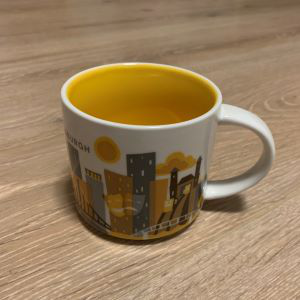

In [5]:
# Download an example image
IM_URL = "https://cvbp-secondary.z19.web.core.windows.net/images/cvbp_cup.jpg"
im_path = os.path.join(data_path(), "example.jpg")
urllib.request.urlretrieve(IM_URL, im_path)

im = Image.open(im_path)
im

Using the `predict()` method, we ask the model to detect how many objects and what they are on this image.  In this case, the only object is "cup".

In [6]:
detections = detector.predict(im)

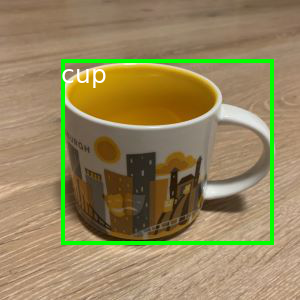

In [7]:
plot_boxes(im, detections["det_bboxes"], plot_settings=PlotSettings(rect_color=(0, 255, 0)))

In [8]:
detections

[{Bbox object: [left=61, top=59, right=273, bottom=244] | <cup> | label:47 | path:None} | score: 0.9996309280395508]

## From WebCam Stream

Now, we use a WebCam stream for object detection. We use `ipywebrtc` to start a webcam and get the video stream which is sent to the notebook's widget. Note that Jupyter widgets are quite unstable - if the widget below does not show then see the "Troubleshooting" section in this [FAQ](../classification/FAQ.md) for possible fixes. 

In [9]:
# Webcam
w_cam = CameraStream(
    constraints={
        'facing_mode': 'user',
        'audio': False,
        'video': { 'width': 200, 'height': 200 }
    },
    layout=Layout(width='200px')
)
# Image recorder for taking a snapshot
w_imrecorder = ImageRecorder(stream=w_cam, layout=Layout(padding='0 0 0 50px'))
# Label widget to show our object detection results
w_im = widgets.Image(layout=Layout(width='200px'))

def detect_frame(_):
    """ Detect objects on an image snapshot by using a pretrained model
    """
    # Once capturing started, remove the capture widget since we don't need it anymore
    if w_imrecorder.layout.display != 'none':
        w_imrecorder.layout.display = 'none'
        
    try:
        # Get the image and convert to RGB
        im = Image.open(io.BytesIO(w_imrecorder.image.value)).convert('RGB')
        
        # Process the captured image
        detections = detector.predict(im)
        plot_boxes(im, detections["det_bboxes"], plot_settings=PlotSettings(rect_color=(0, 255, 0)))
        
        # Convert the processed image back into the image widget for display
        f = io.BytesIO()
        im.save(f, format='png')
        w_im.value = f.getvalue()
        
    except OSError:
        # If im_recorder doesn't have valid image data, skip it. 
        pass
    
    # Taking the next snapshot programmatically
    w_imrecorder.recording = True

# Register detect_frame as a callback. Will be called whenever image.value changes. 
w_imrecorder.image.observe(detect_frame, 'value')

In [10]:
# Show widgets
HBox([w_cam, w_imrecorder, w_im])

Now, click the **capture button** in the widget to start object detection. Labels and bounding boxes are displayed to show the most probable objects predicted by the model for an image snapshot.

![Example Webcam Image](media/00_webcam_snapshot.png)

# Conclusion
In this notebook, we used a simple example to demonstrate how to use a pretrained model to detect objects on images. The model is limited to only predict object labels that are part of the COCO training samples. In the [training introduction notebook](01_training_introduction.ipynb), we will learn how to fine-tune a model on our own data.

In [11]:
# Stop the model and webcam
Widget.close_all()

In [12]:
# Preserve some of the notebook outputs
detections = [
    (x.label_idx, x.label_name, [(x.left, x.top), (x.right, x.bottom)]) 
    for x in detections["det_bboxes"]
]
sb.glue("detection_bounding_box", detections)